# Market Basket Prediction 

## Predicting which products will Instacart customers buy again 

### Overview
Instacart is a grocery ordering and delivery app. Users select products from a local grocery store through the Instacart app, then personal shoppers do the in-store shopping and deliver to the users. Instacart has released an anonymized dataset for a kaggle competition which contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, between 4 and 100 of their orders, with the sequence of products purchased in each order is provided. The data set is Accessed from https://www.instacart.com/datasets/grocery-shopping-2017  

The data dictionary is available here https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b

The objective of this project is to **predict which previously purchased products will be in a user’s next order.** This will be used in the app's 'Buy iy Again' feature. The business objective is to save customers time and thereby increasing the value of the service and customer retention by suggesting relevant products as users shop using the app. 

![buy_again](buy_again.png)


In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

import os, glob

# selection, processing
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 

# models
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

# metrics
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import time
from collections import Counter

pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore') # Ignore all warnings

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 


### About the Data

The data is distributed across six different CSV files. To understand the data better let us read all the files as data frame objects and preview their content.

In [3]:
# read the files and set dtypes for efficint memory
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
priors = pd.read_csv('order_products__prior.csv',dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})
train = pd.read_csv('order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})
orders = pd.read_csv('orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})
products = pd.read_csv('products.csv', dtype={
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'product_name', 'aisle_id', 'department_id'])
#sample_submission = pd.read_csv('sample_submission.csv')

### Aisles

In [5]:
# Shape and preview aisles file
print('Aisles shape:', aisles.shape)
aisles.head()

Aisles shape: (134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


### Departments

In [6]:
print('Departments shape:', departments.shape)
departments.head()

Departments shape: (21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


### Prior orders

In [7]:
print('orders prior shape', priors.shape)
priors.head()

orders prior shape (32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### Train Orders

In [8]:
# Examine orders_train table
print('Order train shape:', train.shape)
train.head()

Order train shape: (1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


### Orders

In [9]:

print('Orders shape:', orders.shape)
orders.head()

Orders shape: (3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


### Products

In [10]:
print('Products shape:', products.shape)
products.head()

Products shape: (49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


The orders file has all the information about a given order by order_id such as user who has made the order, and when was it purchased. The variables in order_train and order_prior are same. We've mentioned above that the dataset contains 4 to 100 orders of a customer and our goal is to predict the products that a user will reordered. To make this possible, the last order of the user has been taken out and divided into train and test sets. All the prior order informations of the customer are present in order_prior file. We can also note that there is a variable in orders.csv file called eval_set which tells us whether a given order row is  a prior, train or test order.

The data files are all linked together with common identifiers and the following graph shows their relations and how they can be combined together. (from https://www.kaggle.com/c/instacart-market-basket-analysis/discussion/33128)



![Table relation](files.png)

We'll extract different features for modeling. Before that let's explore the raw data


### Data Exploration
#### Order amount for each set
Of the more than 3.4 million orders, the majority is from previous orders. 

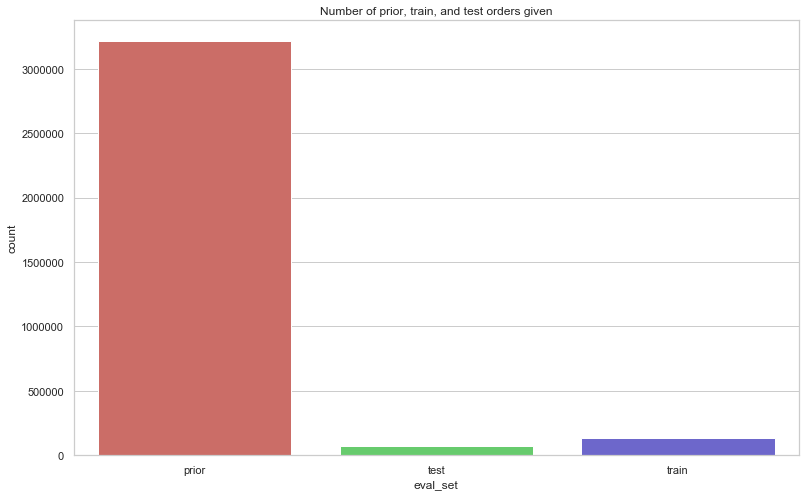

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64


In [77]:
# Compare each set count 
plt.figure(figsize=(13,8))
sns.countplot(x='eval_set', data=orders, palette='hls')
plt.title('Number of prior, train, and test orders given')
plt.show()

print(orders['eval_set'].value_counts())

In [78]:
# Total number of orders
print(orders['eval_set'].value_counts().sum())

3421083


In [79]:
print('Number of unique users', users.shape[0])

Number of unique users 206209


The orders above correspond to a total of 206,209 users of which 75000 are test users and 131209 are train users. Since there is only one user per order for train and test sets, we can simply take the length of train and test orders to get the number users corresponding to them.  

#### Orders per day of week
There is no significant difference between order amounts in different days of the week except for the week day 0 and 1. The data dictionary didn't give information on what days correspond to the numbers given. 


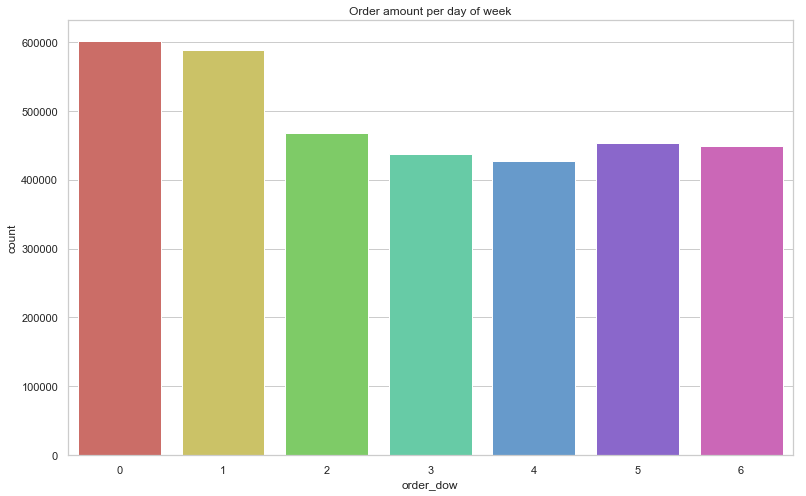

0    600905
1    587478
2    467260
5    453368
6    448761
3    436972
4    426339
Name: order_dow, dtype: int64


In [80]:
# Compare orders per day of the week 
plt.figure(figsize=(13,8))
sns.countplot(x='order_dow', data=orders, palette='hls')
plt.title('Order amount per day of week')
plt.show()
# print the values
print(orders['order_dow'].value_counts())

#### Orders per Hour of Day

As would be expected, most of the orders are made during the usual active hours of 9:00AM and 5:00PM

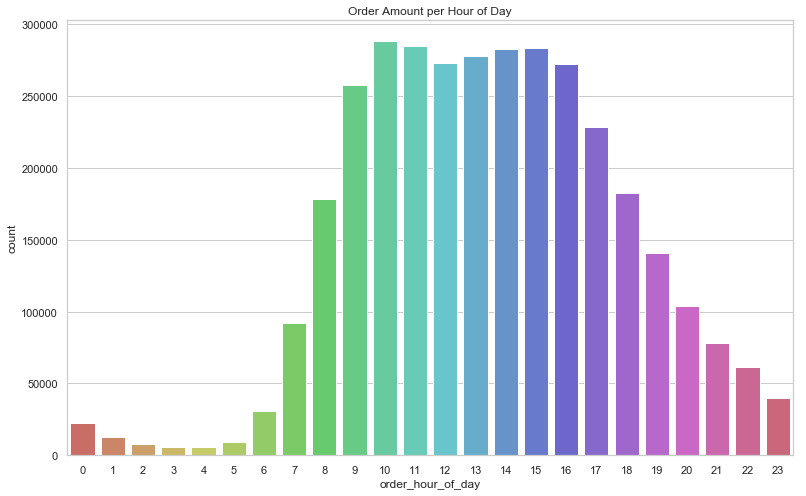

10    288418
11    284728
15    283639
14    283042
13    277999
12    272841
16    272553
9     257812
17    228795
18    182912
8     178201
19    140569
20    104292
7      91868
21     78109
22     61468
23     40043
6      30529
0      22758
1      12398
5       9569
2       7539
4       5527
3       5474
Name: order_hour_of_day, dtype: int64


In [81]:
# Compare orders per hour of day
plt.figure(figsize=(13,8))
sns.countplot(x='order_hour_of_day', data=orders, palette='hls')
plt.title('Order Amount per Hour of Day')
plt.show()
# print the values
print(orders['order_hour_of_day'].value_counts())

#### Days Since Last Order
We notice that there are spikes in number of orders every seventh day and at the turn of the month. Which indicates a pattern in users habits. 

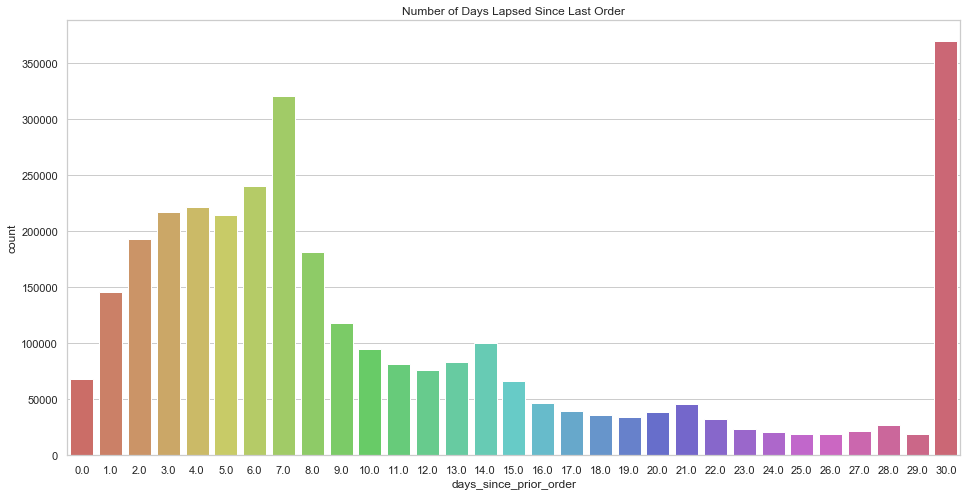

In [86]:
# Order intervals 
plt.figure(figsize=(16,8))
sns.countplot(x='days_since_prior_order', data=orders, palette='hls')
plt.title('Number of Days Lapsed Since Last Order')
plt.show()


#### Most Popular Producs
To see the most ordered products let's merge prior orders with the products table firse

In [100]:
# merge to get product name and order information in the same table 
order_products_prior = pd.merge(priors, products, on='product_id', how='left')

In [101]:
# inspect
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,2,28985,2,1,Michigan Organic Kale,83,4
2,2,9327,3,0,Garlic Powder,104,13
3,2,45918,4,1,Coconut Butter,19,13
4,2,30035,5,0,Natural Sweetener,17,13


In [110]:
# Count the most common products  
cnt_srs = order_products_prior['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'count']
cnt_srs

,product_name,count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


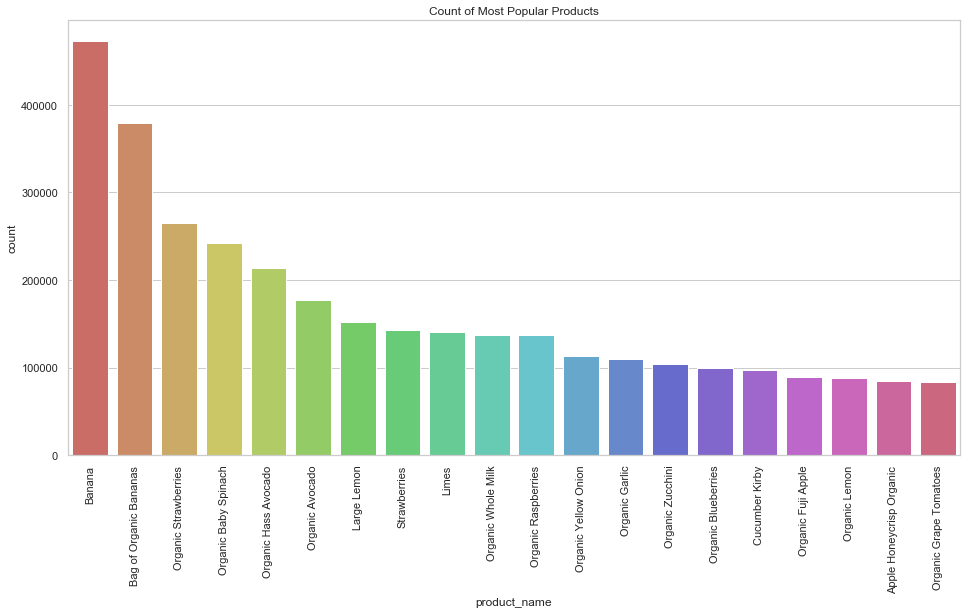

In [112]:
# Order intervals 
plt.figure(figsize=(16,8))
sns.barplot(x='product_name', y='count', data=cnt_srs, palette='hls')
plt.title('Count of Most Popular Products')
plt.xticks(rotation=90)
plt.show()

Interestingly the first most popular product is banana and the second most popular product is also banana. Most of the top 20 products we ploted above are organic products and except for organic whole milk, all others are either fruits or vegitables. here it is not clear whether that says a lot about eating habits of Instacart users or American consumers in general. 

We can do similar combinations to make more visualization and analysis for Aisles, and departments. We now have a better feel of the dataset. 

### Problem Approach and Feature Generation
Our approach to make future prediction is to make a list of all unique products that a user has ordered previously and predict the probabiity that each individual product will be reordered by the same user. The list will be a unique user product pair. We will then split the 'train' data in to training and evaluation sets. That way we will be able to evaluate the model before making prediction useing the test set. 

We'll create features at users, product, and order labels and the feature names will be self explanatory. 

In [4]:
#Reorder rate. reorder to order ratio
#product features
prods = pd.DataFrame()
prods['orders'] = priors.groupby(priors.product_id).size().astype(np.int32)
prods['reorders'] = priors['reordered'].groupby(priors.product_id).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)

In [121]:
products.head()

,product_id,aisle_id,department_id,orders,reorders,reorder_rate
product_id,,,,,,
1,1,61,19,1852.0,1136.0,0.613391
2,2,104,13,90.0,12.0,0.133333
3,3,94,7,277.0,203.0,0.732852
4,4,38,1,329.0,147.0,0.446809
5,5,5,13,15.0,9.0,0.600000


In [5]:
# Drop product name to help with memory issues later and use user_instead
products.drop('product_name', 1, inplace=True)

In [6]:
#add order and priors
orders.set_index('order_id', inplace=True, drop=False)
priors = priors.join(orders, on='order_id', rsuffix='_')
priors.drop('order_id_', inplace=True, axis=1)

In [7]:
# user features
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)

users = pd.DataFrame()
users['total_items'] = priors.groupby('user_id').size().astype(np.int16)
users['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = (users.all_products.map(len)).astype(np.int16)

users = users.join(usr)
# Average size of user basket 
users['average_basket'] = (users.total_items / users.nb_orders).astype(np.float32)
print('Number of unique users', users.shape[0])

Number of unique users 206209


In [8]:
# userXproduct features. User product pair 
priors['user_product'] = priors.product_id + priors.user_id * 100000

In [125]:
# preview 
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_product
0,2,33120,1,1,202279,prior,3,5,9,8.0,-1246903360
1,2,28985,2,1,202279,prior,3,5,9,8.0,-1246907495
2,2,9327,3,0,202279,prior,3,5,9,8.0,-1246927153
3,2,45918,4,1,202279,prior,3,5,9,8.0,-1246890562
4,2,30035,5,0,202279,prior,3,5,9,8.0,-1246906445


In [9]:
# Aggregates every unique product that a unique user has previously bought
d= dict()
for row in priors.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1,
                (row.order_number, row.order_id),
                row.add_to_cart_order)
    else:
        d[z] = (d[z][0] + 1,
                max(d[z][1], (row.order_number, row.order_id)),
                d[z][2] + row.add_to_cart_order)

In [10]:
# Convert dictionary to pandas data frame 

userXproduct = pd.DataFrame.from_dict(d, orient='index')
del d
userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
userXproduct.last_order_id = userXproduct.last_order_id.map(lambda x: x[1]).astype(np.int32)
userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)
print('number of user product pair ', len(userXproduct))


number of user product pair  13293564


Since the total user product pair is too huge to use, we'll use the ones with 'train' label for modeling. 

In [11]:
# Split train / test orders

test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

train.set_index(['order_id', 'product_id'], inplace=True, drop=False)

In [132]:
train_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,,
1187899,1187899,1,train,11,4,8,14.0
1492625,1492625,2,train,15,1,11,30.0
2196797,2196797,5,train,5,0,11,6.0
525192,525192,7,train,21,2,11,6.0
880375,880375,8,train,4,1,14,10.0


In [181]:
test_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,,
2774568,2774568,3,test,13,5,15,11.0
329954,329954,4,test,6,3,12,30.0
1528013,1528013,6,test,4,3,16,22.0
1376945,1376945,11,test,8,6,11,8.0
1356845,1356845,12,test,6,1,20,30.0


In [12]:
# build list of candidate products to reorder, with features

def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in selected_orders.itertuples():
        i+=1
        if i%1000000 == 0: print('order row',i)
        order_id = row.order_id
        user_id = row.user_id
        user_products = users.all_products[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in train.index for product in user_products]
            '''Returns a true/false list whether or not a certain product is in a certain order 
            based on previously built list of all unique products a user has ever bought.
            '''
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    # User level features
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    
    # Order level features
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    # Product level features
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    # user-product pair features
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    
    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    
    return (df, labels)

In [13]:
# Create the list 
df_train, labels = features(train_orders, labels_given=True)



build candidate list


In [191]:
labels[:10]

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 1], dtype=int8)

We will use the following features for modeling. This makes it easier to select fewer features if needed.  

In [14]:
# features to use 
f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last'] 

In [15]:
# add the label. this will be target variable
df_train['reordered'] = labels

In [25]:
# shape before sampling
df_train.shape

(8474661, 22)

In [16]:
# Use only half of the data
df_train = df_train.sample(frac=0.5, random_state=42)

In [27]:
# sample data shape
df_train.shape

(4237330, 22)

In [193]:
# preview
df_train.head()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last,reordered
0,1187899,17122,11,59,18,19.0,5.363636,8,14.0,0.736842,24,4,13880,9377.0,0.675576,1,0.090909,6.0,0.090909,6,7,0
1,1187899,196,11,59,18,19.0,5.363636,8,14.0,0.736842,77,7,35791,27791.0,0.776480,10,0.909091,1.4,0.909091,1,0,1
2,1187899,26405,11,59,18,19.0,5.363636,8,14.0,0.736842,54,17,1214,536.0,0.441516,2,0.181818,5.0,0.181818,7,1,1
3,1187899,46149,11,59,18,19.0,5.363636,8,14.0,0.736842,77,7,8558,6953.0,0.812456,3,0.272727,3.0,0.272727,1,0,1
4,1187899,14084,11,59,18,19.0,5.363636,8,14.0,0.736842,91,16,15935,12923.0,0.810982,1,0.090909,2.0,0.090909,10,0,0


The labeled train data can now be split in to training and evaluation set. That way we will be able to evaluate the performance of our models. 

In [17]:
# define target variable and other features
X = df_train.drop('reordered', 1)
Y = df_train['reordered']

In [20]:
# split the train data for evaluation 

X_train, X_eval, y_train, y_eval = train_test_split(
    X, Y, test_size=0.2, random_state=2)

## Prediction
### Gradient Boosting with Light GBM Model
LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is fast and suited for large datasets and as a result we will try it as our first model. Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow.

Documentation
https://lightgbm.readthedocs.io/en/latest/


In [21]:
#preparing for Light GBM
lgb_train = lgb.Dataset(X_train[f_to_use], label=y_train)
lgb_eval = lgb.Dataset(X_eval[f_to_use], y_eval, reference = lgb_train)

In [29]:
params = {}
params['task'] = 'train'
params['learning_rate'] = 0.05
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = {'auc', 'binary_logloss'}
params['sub_feature'] = 0.5
params['num_leaves'] = 600
params['min_data'] = 200
params['max_bin'] = 100#used to deal with overfitting.
params['num_iterations'] = 1000
params['feature_fraction'] = 0.8
params['bagging_fraction'] = 0.95
params['num_boost_round'] = 400
params['bagging_freq'] = 5


In [24]:
# Train a light GBM model 

lgb_model = lgb.train(params, lgb_train, valid_sets = lgb_eval, early_stopping_rounds=15)



[1]	valid_0's binary_logloss: 0.31124	valid_0's auc: 0.824173
Training until validation scores don't improve for 15 rounds.
[2]	valid_0's binary_logloss: 0.304099	valid_0's auc: 0.825312
[3]	valid_0's binary_logloss: 0.298196	valid_0's auc: 0.825805
[4]	valid_0's binary_logloss: 0.293127	valid_0's auc: 0.826442
[5]	valid_0's binary_logloss: 0.289597	valid_0's auc: 0.826503
[6]	valid_0's binary_logloss: 0.285676	valid_0's auc: 0.826993
[7]	valid_0's binary_logloss: 0.282224	valid_0's auc: 0.827439
[8]	valid_0's binary_logloss: 0.27914	valid_0's auc: 0.827743
[9]	valid_0's binary_logloss: 0.276377	valid_0's auc: 0.82801
[10]	valid_0's binary_logloss: 0.2739	valid_0's auc: 0.828136
[11]	valid_0's binary_logloss: 0.272103	valid_0's auc: 0.828008
[12]	valid_0's binary_logloss: 0.270486	valid_0's auc: 0.827719
[13]	valid_0's binary_logloss: 0.268556	valid_0's auc: 0.828016
[14]	valid_0's binary_logloss: 0.267228	valid_0's auc: 0.827672
[15]	valid_0's binary_logloss: 0.265603	valid_0's auc: 0

[129]	valid_0's binary_logloss: 0.245362	valid_0's auc: 0.833969
[130]	valid_0's binary_logloss: 0.245353	valid_0's auc: 0.833982
[131]	valid_0's binary_logloss: 0.245336	valid_0's auc: 0.834011
[132]	valid_0's binary_logloss: 0.245326	valid_0's auc: 0.83403
[133]	valid_0's binary_logloss: 0.245324	valid_0's auc: 0.834031
[134]	valid_0's binary_logloss: 0.245316	valid_0's auc: 0.834049
[135]	valid_0's binary_logloss: 0.245303	valid_0's auc: 0.834074
[136]	valid_0's binary_logloss: 0.245285	valid_0's auc: 0.834105
[137]	valid_0's binary_logloss: 0.245277	valid_0's auc: 0.834122
[138]	valid_0's binary_logloss: 0.245263	valid_0's auc: 0.834148
[139]	valid_0's binary_logloss: 0.245259	valid_0's auc: 0.834165
[140]	valid_0's binary_logloss: 0.245247	valid_0's auc: 0.834183
[141]	valid_0's binary_logloss: 0.245237	valid_0's auc: 0.834206
[142]	valid_0's binary_logloss: 0.245229	valid_0's auc: 0.834222
[143]	valid_0's binary_logloss: 0.24522	valid_0's auc: 0.834242
[144]	valid_0's binary_logl

[256]	valid_0's binary_logloss: 0.244794	valid_0's auc: 0.83502
[257]	valid_0's binary_logloss: 0.244795	valid_0's auc: 0.835017
[258]	valid_0's binary_logloss: 0.244796	valid_0's auc: 0.835015
[259]	valid_0's binary_logloss: 0.244797	valid_0's auc: 0.835012
[260]	valid_0's binary_logloss: 0.244799	valid_0's auc: 0.83501
[261]	valid_0's binary_logloss: 0.244799	valid_0's auc: 0.835013
[262]	valid_0's binary_logloss: 0.244797	valid_0's auc: 0.83502
[263]	valid_0's binary_logloss: 0.244794	valid_0's auc: 0.835021
[264]	valid_0's binary_logloss: 0.244793	valid_0's auc: 0.835024
[265]	valid_0's binary_logloss: 0.24479	valid_0's auc: 0.83503
[266]	valid_0's binary_logloss: 0.244789	valid_0's auc: 0.835036
[267]	valid_0's binary_logloss: 0.244791	valid_0's auc: 0.835032
[268]	valid_0's binary_logloss: 0.244793	valid_0's auc: 0.835029
[269]	valid_0's binary_logloss: 0.244796	valid_0's auc: 0.835027
[270]	valid_0's binary_logloss: 0.2448	valid_0's auc: 0.835023
[271]	valid_0's binary_logloss: 

The model has trained with 650 itterations using binary_logloss auc loss functions. 

#### Evaluation
let's make a prediction for the test set so that and evaluate the result. The prediction returns probability scores between 0 and 1. We'll use a threshold value to change it to binary. 

In [25]:
# Predict for evaluation set 
X_eval['pred'] = lgb_model.predict(X_eval[f_to_use], num_iterations = lgb_model.best_iteration)

In [26]:
X_eval['pred'].head()

6225341    0.019294
6083169    0.002824
4223455    0.062698
8327891    0.076076
1613192    0.034598
Name: pred, dtype: float64

In [27]:
# Change to binary for evaluation 
X_eval['pred'] = np.where(X_eval['pred'] >= 0.5, 1, X_eval['pred'].astype(int))

In [28]:
# Evaluating validation set 
#Confusion matrix for validation set 
print('Confusion matrix')
print(confusion_matrix(y_eval, X_eval['pred']))

# Classification report 
print(classification_report(y_eval, X_eval['pred']))


Confusion matrix
[[755891   8605]
 [ 67950  15020]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95    764496
           1       0.64      0.18      0.28     82970

   micro avg       0.91      0.91      0.91    847466
   macro avg       0.78      0.58      0.62    847466
weighted avg       0.89      0.91      0.89    847466



In [30]:
#Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(X_eval['pred'], y_eval)
print('Accuracy:', accuracy)

Accuracy: 0.9096659924999941


The confusion matrix and classification report do not seem promising although the accuracy score seems high. We will use this model as a benchmark and try to improve the score by first balancing the classes and also by using other models. 

## Adjust Class Imbalance 



The number of user product pairs not reordered outnumbers the reordered ones. Balancing the classes is likely to give us a better result. in addition it will also help us reduce the data to a size that most models can handle.  

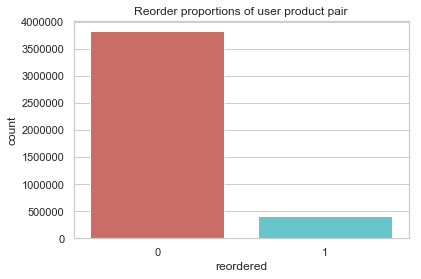

0    3822681
1     414649
Name: reordered, dtype: int64


In [30]:
sns.countplot(x='reordered', data=df_train, palette='hls')
plt.title('Reorder proportions of user product pair')
plt.show()
print(df_train['reordered'].value_counts())

1    1000000
0    1000000
Name: reordered, dtype: int64
Balanced train class


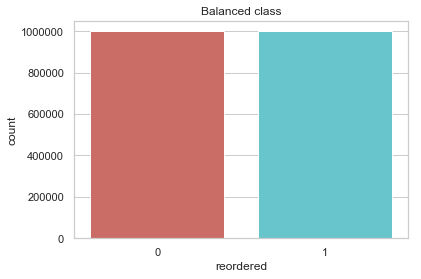

In [18]:
#Import module and resampling 

from sklearn.utils import resample

# Separate majority and minority classes
data_majority = df_train[df_train.reordered==0]
data_minority = df_train[df_train.reordered==1]
 
# Downsample majority overall class

data_majority_downsampled = resample(data_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=1000000,     # new sample size
                                 random_state=123) # reproducible results
 
# Upsample minority overall class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,    # Must be true for minority upsampling
                                 n_samples=1000000,     # new sample size
                                 random_state=123) # reproducible results
# Combine majority class with upsampled minority overall class
df_train_resampled = pd.concat([data_minority_upsampled, data_majority_downsampled])
 
# Display new class counts
print(df_train_resampled.reordered.value_counts())
print('Balanced train class')

sns.countplot(x='reordered', data=df_train_resampled, palette='hls')
plt.title('Balanced class')
plt.show()

In [19]:
df_train_resampled.isnull().sum()

order_id                            0
product_id                          0
user_total_orders                   0
user_total_items                    0
total_distinct_items                0
user_average_days_between_orders    0
user_average_basket                 0
order_hour_of_day                   0
days_since_prior_order              0
days_since_ratio                    7
aisle_id                            0
department_id                       0
product_orders                      0
product_reorders                    0
product_reorder_rate                0
UP_orders                           0
UP_orders_ratio                     0
UP_average_pos_in_cart              0
UP_reorder_rate                     0
UP_orders_since_last                0
UP_delta_hour_vs_last               0
reordered                           0
dtype: int64

In [20]:
# Replace missing values with the mean
df_train_resampled = df_train_resampled.fillna(df_train_resampled.mean())

In [21]:
# Define target variable 
X = df_train_resampled.drop('reordered', 1)
Y = df_train_resampled['reordered']

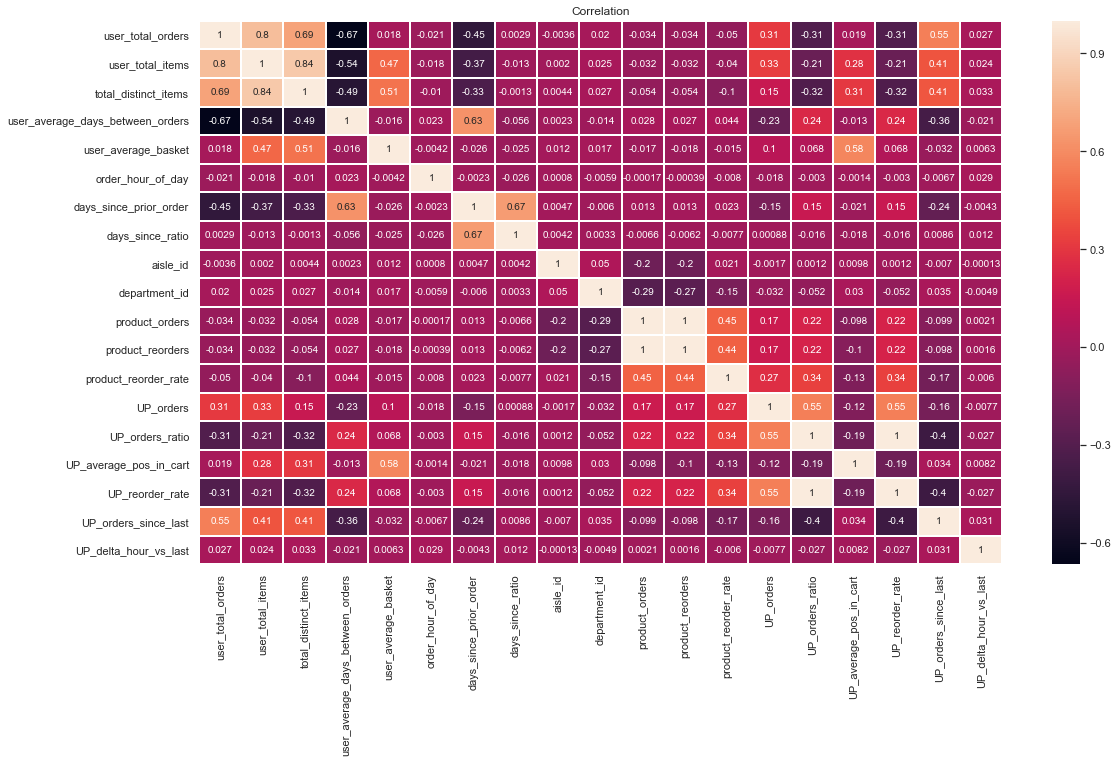

In [64]:
# Visualize correlations between continious variables
plt.figure(figsize=(18,10))
sns.heatmap(df_train_resampled[f_to_use].corr(),linewidth = 1,annot= True)
plt.title('Correlation')
plt.show()

In [36]:
X.shape

(3000000, 21)

In [37]:
# split the resampled train data for evaluation 
X_train_gbm, X_eval_gbm, y_train_gbm, y_eval_gbm = train_test_split(
    X, Y, test_size=0.2, random_state=2)

In [38]:
X_train_gbm.shape

(2400000, 21)

#### Light GBM with resampled data

In [39]:
#preparing resampled data for Light GBM
lgb_train_gbm = lgb.Dataset(X_train_gbm, label=y_train_gbm)
lgb_eval_gbm = lgb.Dataset(X_eval_gbm, y_eval_gbm, reference = lgb_train_gbm)

In [40]:
# define and train the model with the resampled data and similar parameters
start_time = time.clock() # time it 
lgb_model_gbm = lgb.train(params, lgb_train_gbm, valid_sets = lgb_eval_gbm, early_stopping_rounds=15)
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2))) # run time 

[1]	valid_0's binary_logloss: 0.677577	valid_0's auc: 0.825377
Training until validation scores don't improve for 15 rounds.
[2]	valid_0's binary_logloss: 0.665873	valid_0's auc: 0.823369
[3]	valid_0's binary_logloss: 0.655273	valid_0's auc: 0.818338
[4]	valid_0's binary_logloss: 0.642916	valid_0's auc: 0.825273
[5]	valid_0's binary_logloss: 0.63173	valid_0's auc: 0.82804
[6]	valid_0's binary_logloss: 0.621517	valid_0's auc: 0.829521
[7]	valid_0's binary_logloss: 0.612134	valid_0's auc: 0.830366
[8]	valid_0's binary_logloss: 0.603566	valid_0's auc: 0.830857
[9]	valid_0's binary_logloss: 0.595725	valid_0's auc: 0.831167
[10]	valid_0's binary_logloss: 0.590009	valid_0's auc: 0.83078
[11]	valid_0's binary_logloss: 0.583243	valid_0's auc: 0.831318
[12]	valid_0's binary_logloss: 0.577008	valid_0's auc: 0.831648
[13]	valid_0's binary_logloss: 0.571274	valid_0's auc: 0.831935
[14]	valid_0's binary_logloss: 0.565979	valid_0's auc: 0.832165
[15]	valid_0's binary_logloss: 0.561144	valid_0's auc:

[129]	valid_0's binary_logloss: 0.48459	valid_0's auc: 0.847232
[130]	valid_0's binary_logloss: 0.48442	valid_0's auc: 0.847344
[131]	valid_0's binary_logloss: 0.484284	valid_0's auc: 0.847443
[132]	valid_0's binary_logloss: 0.484142	valid_0's auc: 0.847548
[133]	valid_0's binary_logloss: 0.483986	valid_0's auc: 0.847654
[134]	valid_0's binary_logloss: 0.483826	valid_0's auc: 0.847763
[135]	valid_0's binary_logloss: 0.483671	valid_0's auc: 0.84788
[136]	valid_0's binary_logloss: 0.4835	valid_0's auc: 0.848001
[137]	valid_0's binary_logloss: 0.483353	valid_0's auc: 0.848112
[138]	valid_0's binary_logloss: 0.483201	valid_0's auc: 0.848225
[139]	valid_0's binary_logloss: 0.483047	valid_0's auc: 0.848334
[140]	valid_0's binary_logloss: 0.482873	valid_0's auc: 0.848457
[141]	valid_0's binary_logloss: 0.48274	valid_0's auc: 0.848552
[142]	valid_0's binary_logloss: 0.482612	valid_0's auc: 0.84865
[143]	valid_0's binary_logloss: 0.482488	valid_0's auc: 0.848743
[144]	valid_0's binary_logloss: 

[256]	valid_0's binary_logloss: 0.469707	valid_0's auc: 0.858045
[257]	valid_0's binary_logloss: 0.469597	valid_0's auc: 0.858127
[258]	valid_0's binary_logloss: 0.469492	valid_0's auc: 0.858207
[259]	valid_0's binary_logloss: 0.469399	valid_0's auc: 0.858274
[260]	valid_0's binary_logloss: 0.469303	valid_0's auc: 0.858345
[261]	valid_0's binary_logloss: 0.469223	valid_0's auc: 0.858404
[262]	valid_0's binary_logloss: 0.469111	valid_0's auc: 0.858486
[263]	valid_0's binary_logloss: 0.469031	valid_0's auc: 0.858545
[264]	valid_0's binary_logloss: 0.468955	valid_0's auc: 0.858601
[265]	valid_0's binary_logloss: 0.468838	valid_0's auc: 0.858687
[266]	valid_0's binary_logloss: 0.46874	valid_0's auc: 0.858758
[267]	valid_0's binary_logloss: 0.468649	valid_0's auc: 0.858827
[268]	valid_0's binary_logloss: 0.468547	valid_0's auc: 0.858902
[269]	valid_0's binary_logloss: 0.468474	valid_0's auc: 0.85896
[270]	valid_0's binary_logloss: 0.468377	valid_0's auc: 0.859036
[271]	valid_0's binary_logl

[383]	valid_0's binary_logloss: 0.458219	valid_0's auc: 0.866443
[384]	valid_0's binary_logloss: 0.458116	valid_0's auc: 0.866517
[385]	valid_0's binary_logloss: 0.458015	valid_0's auc: 0.86659
[386]	valid_0's binary_logloss: 0.457911	valid_0's auc: 0.866665
[387]	valid_0's binary_logloss: 0.457837	valid_0's auc: 0.866723
[388]	valid_0's binary_logloss: 0.457729	valid_0's auc: 0.866799
[389]	valid_0's binary_logloss: 0.457626	valid_0's auc: 0.866875
[390]	valid_0's binary_logloss: 0.457532	valid_0's auc: 0.866942
[391]	valid_0's binary_logloss: 0.457463	valid_0's auc: 0.866996
[392]	valid_0's binary_logloss: 0.4574	valid_0's auc: 0.867042
[393]	valid_0's binary_logloss: 0.457339	valid_0's auc: 0.867089
[394]	valid_0's binary_logloss: 0.457276	valid_0's auc: 0.867132
[395]	valid_0's binary_logloss: 0.457187	valid_0's auc: 0.867192
[396]	valid_0's binary_logloss: 0.457127	valid_0's auc: 0.86724
[397]	valid_0's binary_logloss: 0.457068	valid_0's auc: 0.867284
[398]	valid_0's binary_loglos

[510]	valid_0's binary_logloss: 0.447887	valid_0's auc: 0.873813
[511]	valid_0's binary_logloss: 0.447764	valid_0's auc: 0.873894
[512]	valid_0's binary_logloss: 0.447684	valid_0's auc: 0.873953
[513]	valid_0's binary_logloss: 0.447596	valid_0's auc: 0.874011
[514]	valid_0's binary_logloss: 0.44748	valid_0's auc: 0.874087
[515]	valid_0's binary_logloss: 0.447397	valid_0's auc: 0.874147
[516]	valid_0's binary_logloss: 0.447331	valid_0's auc: 0.874197
[517]	valid_0's binary_logloss: 0.447284	valid_0's auc: 0.874232
[518]	valid_0's binary_logloss: 0.447209	valid_0's auc: 0.874282
[519]	valid_0's binary_logloss: 0.447109	valid_0's auc: 0.874354
[520]	valid_0's binary_logloss: 0.447027	valid_0's auc: 0.874411
[521]	valid_0's binary_logloss: 0.446938	valid_0's auc: 0.874475
[522]	valid_0's binary_logloss: 0.446882	valid_0's auc: 0.874517
[523]	valid_0's binary_logloss: 0.446809	valid_0's auc: 0.874567
[524]	valid_0's binary_logloss: 0.446744	valid_0's auc: 0.874616
[525]	valid_0's binary_log

[637]	valid_0's binary_logloss: 0.438087	valid_0's auc: 0.880632
[638]	valid_0's binary_logloss: 0.438009	valid_0's auc: 0.880683
[639]	valid_0's binary_logloss: 0.43794	valid_0's auc: 0.88073
[640]	valid_0's binary_logloss: 0.437848	valid_0's auc: 0.880793
[641]	valid_0's binary_logloss: 0.437757	valid_0's auc: 0.88085
[642]	valid_0's binary_logloss: 0.437674	valid_0's auc: 0.880907
[643]	valid_0's binary_logloss: 0.437608	valid_0's auc: 0.880952
[644]	valid_0's binary_logloss: 0.437517	valid_0's auc: 0.881009
[645]	valid_0's binary_logloss: 0.437436	valid_0's auc: 0.881059
[646]	valid_0's binary_logloss: 0.43736	valid_0's auc: 0.88111
[647]	valid_0's binary_logloss: 0.437297	valid_0's auc: 0.881152
[648]	valid_0's binary_logloss: 0.437209	valid_0's auc: 0.88121
[649]	valid_0's binary_logloss: 0.437129	valid_0's auc: 0.881264
[650]	valid_0's binary_logloss: 0.437052	valid_0's auc: 0.881317
[651]	valid_0's binary_logloss: 0.436981	valid_0's auc: 0.881366
[652]	valid_0's binary_logloss:

[764]	valid_0's binary_logloss: 0.429157	valid_0's auc: 0.886674
[765]	valid_0's binary_logloss: 0.429075	valid_0's auc: 0.886728
[766]	valid_0's binary_logloss: 0.429	valid_0's auc: 0.88678
[767]	valid_0's binary_logloss: 0.428915	valid_0's auc: 0.886839
[768]	valid_0's binary_logloss: 0.428855	valid_0's auc: 0.886884
[769]	valid_0's binary_logloss: 0.42881	valid_0's auc: 0.886913
[770]	valid_0's binary_logloss: 0.42872	valid_0's auc: 0.886974
[771]	valid_0's binary_logloss: 0.428633	valid_0's auc: 0.887027
[772]	valid_0's binary_logloss: 0.428541	valid_0's auc: 0.887088
[773]	valid_0's binary_logloss: 0.428465	valid_0's auc: 0.887136
[774]	valid_0's binary_logloss: 0.428379	valid_0's auc: 0.887195
[775]	valid_0's binary_logloss: 0.428297	valid_0's auc: 0.887249
[776]	valid_0's binary_logloss: 0.428216	valid_0's auc: 0.887303
[777]	valid_0's binary_logloss: 0.428148	valid_0's auc: 0.887346
[778]	valid_0's binary_logloss: 0.428116	valid_0's auc: 0.887368
[779]	valid_0's binary_logloss:

[891]	valid_0's binary_logloss: 0.420937	valid_0's auc: 0.892123
[892]	valid_0's binary_logloss: 0.420862	valid_0's auc: 0.892172
[893]	valid_0's binary_logloss: 0.420798	valid_0's auc: 0.892213
[894]	valid_0's binary_logloss: 0.420737	valid_0's auc: 0.892253
[895]	valid_0's binary_logloss: 0.420703	valid_0's auc: 0.892275
[896]	valid_0's binary_logloss: 0.420624	valid_0's auc: 0.892325
[897]	valid_0's binary_logloss: 0.420568	valid_0's auc: 0.892366
[898]	valid_0's binary_logloss: 0.420526	valid_0's auc: 0.892394
[899]	valid_0's binary_logloss: 0.420465	valid_0's auc: 0.892438
[900]	valid_0's binary_logloss: 0.420408	valid_0's auc: 0.892475
[901]	valid_0's binary_logloss: 0.420373	valid_0's auc: 0.892499
[902]	valid_0's binary_logloss: 0.420304	valid_0's auc: 0.892544
[903]	valid_0's binary_logloss: 0.420245	valid_0's auc: 0.892583
[904]	valid_0's binary_logloss: 0.4202	valid_0's auc: 0.892611
[905]	valid_0's binary_logloss: 0.420158	valid_0's auc: 0.89264
[906]	valid_0's binary_loglo

The model takes fewr iteration to train that the previous. 

In [41]:
# Predict for evaluation set 
X_eval_gbm['reordered'] = lgb_model_gbm.predict(X_eval_gbm, num_iterations = lgb_model_gbm.best_iteration)

In [42]:
# Change to binary for evaluation using lower threshold 
X_eval_gbm['reordered']=np.where(X_eval_gbm['reordered'] > 0.22, 1, X_eval_gbm['reordered'].astype(int))

In [43]:
#Confusion matrix for resampled validation set 
print('Confusion matrix')
print(confusion_matrix(y_eval_gbm, X_eval_gbm['reordered']))

# Classification report 
print(classification_report(y_eval_gbm, X_eval_gbm['reordered']))

Confusion matrix
[[148396 151903]
 [  5813 293888]]
              precision    recall  f1-score   support

           0       0.96      0.49      0.65    300299
           1       0.66      0.98      0.79    299701

   micro avg       0.74      0.74      0.74    600000
   macro avg       0.81      0.74      0.72    600000
weighted avg       0.81      0.74      0.72    600000



In [44]:
#Accuracy for resampled model
from sklearn.metrics import accuracy_score
accuracy_gbm=accuracy_score(X_eval_gbm['reordered'],y_eval_gbm)
print('Accuracy:', accuracy_gbm)

Accuracy: 0.73714


The classification report and confusion matrix result has improved but not good enough to get a useful prediction. 

Most of the features we created are continious variables but the relation between them is not necessarily linear. Light GBM uses a histogram based algorithm to create decision trees i.e it groups continious feature values into discrete bins and as a result it's able to produce a better result with the feature we have. This process also speeds up training and requires lower memory than other boosting methods. We have upsampled the positive class by more than two fold when dealing with class imbalance and that could be the reason why the model has learned and predicted higher proportion of False Positives. Before we balanced the classes, the False Positive rate had a much lower proportion than other counts in the confusion matrix. 

In [45]:
#free up memory 
del X_train_gbm, X_eval_gbm, y_train_gbm, y_eval_gbm

### KNN Classifier

In [22]:
# split the resampled train data for evaluation 
X_train_re, X_eval_re, y_train_re, y_eval_re = train_test_split(
    X, Y, test_size=0.2, random_state=2)

[0.79898333 0.79957667 0.79737667 0.79850667 0.79912667 0.79887333
 0.79838    0.79858667 0.79919333 0.79808333]
Training set score: 1.0

Test set score: 0.7939683333333334
              precision    recall  f1-score   support

           0       0.96      0.62      0.75    300299
           1       0.72      0.97      0.82    299701

   micro avg       0.79      0.79      0.79    600000
   macro avg       0.84      0.79      0.79    600000
weighted avg       0.84      0.79      0.79    600000

Confusion matrix
[[185059 115240]
 [  8379 291322]]


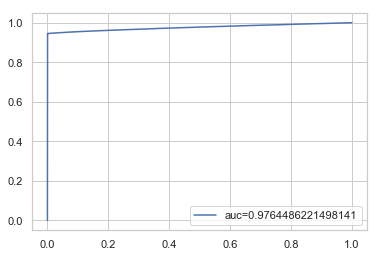


Runtime: 517.97 seconds


In [47]:
# Fit the data to knn model 
start_time = time.clock()
neigh = KNeighborsClassifier(n_neighbors=25, weights='distance')
neigh.fit(X_train_re, y_train_re)
y_knn = neigh.predict(X_eval_re)

# score
score_neigh = cross_val_score(neigh, X, Y, cv=10)
print(score_neigh)
print('Training set score:', neigh.score(X_train_re, y_train_re))
print('\nTest set score:', neigh.score(X_eval_re, y_eval_re))

# Classification report 
print(classification_report(y_eval_re, y_knn))

#Confusion matrix 
print('Confusion matrix')
print(confusion_matrix(y_eval_re, y_knn))

# AUC 
y_pred_proba = neigh.predict_proba(X_eval_re)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_eval_re,  y_pred_proba)
auc = metrics.roc_auc_score(y_eval_re, y_pred_proba)
plt.plot(fpr,tpr,label='auc='+str(auc))
plt.legend(loc=4)
plt.show()
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2)))

KNN classifier has a better precision and recall scores. The training set score is 100% which is a sign of overfitting. KNN looks at the 25 nearest neighbours we picked to predict to which class the test variable belongs by using the distance between the data points as a measure of similarity. This will limit the accuracy because it is difficult to calculate meaningful distance for the categorical variables we have as well as for the other variables which do not have linear relationship. The algorithm assumes linear relationship between continious variables and works best if the measurements are uniform. We have features which measure time intervals between orders and features which simply count the number of items a user buys. Both measurements are not equivalent and as a result limit the performance of the model. We'll apply PCA later which helps normalize the continious variables which is likely to improve prediction. 

### Logistic Regression with L1 regularization parameter and GridSearchCV

In [23]:
# Logistics regression with GridSearchCV
start_time = time.clock()
grid_para = C = {'C': [0.001, 0.01, 0.1, 1, 10]}#Inverse of regularization strength; smaller values specify stronger regularization.
logreg = GridSearchCV(LogisticRegression(penalty='l1'), grid_para, cv=5)
grid_fit_logreg = logreg.fit(X_train_re, y_train_re)
best_logreg = grid_fit_logreg.best_estimator_


# Predict using the test set
y_logreg = best_logreg.predict(X_eval_re)

Training set score: 0.74064875

Test set score: 0.741195
Confusion matrix
[[221975  78324]
 [ 76959 222742]]
              precision    recall  f1-score   support

           0       0.74      0.74      0.74    300299
           1       0.74      0.74      0.74    299701

   micro avg       0.74      0.74      0.74    600000
   macro avg       0.74      0.74      0.74    600000
weighted avg       0.74      0.74      0.74    600000



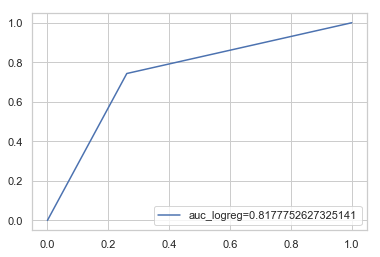


Runtime: 3759.31 seconds


In [24]:
# Compare scores for train and test sets
print('Training set score:', best_logreg.score(X_train_re, y_train_re))
print('\nTest set score:', best_logreg.score(X_eval_re, y_eval_re))

# Ten fold cross validation score to evaluate the model *** Took too long 
#score_logreg = cross_val_score(logreg, X, Y, cv=5)
#print(score_logreg)

#Confusion matrix for logistics regression classifier
print('Confusion matrix')
print(confusion_matrix(y_eval_re, y_logreg))

# Classification report 
print(classification_report(y_eval_re, y_logreg))

# AUC classifier
y_logreg_proba = logreg.predict_proba(X_eval_re)[::,1]
fpr_logreg, tpr_logreg, _ = metrics.roc_curve(y_eval_re,  y_logreg)
auc_logreg = metrics.roc_auc_score(y_eval_re, y_logreg_proba)
plt.plot(fpr_logreg,tpr_logreg,label='auc_logreg='+str(auc_logreg))
plt.legend(loc=4)
plt.show()
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2)))

The overall score has improved and the difference between the training and evaluation sets is very small suggesting that the regularization parameter has helped with overfitting. The algorithm works by iteratively fitting a model to the data while excluding one of the features until the model fit is good enough. Logistic regression assumes that the features are independent of each other but, some of our input variables are correlated as shown in the heatmap above and the regularization seems to have corrected that. 

## Dimentionality reduction 
In this section, we'll use feature selection to reduce the dimentionality of the data. The goal is to select only features that have significance for the prediction and see if we can reduce overfitting, improve accuracy, or reduce run time. We will use Principan Component Analysis(PCA) and SelectKBest sci-kit APIs.  

PCA uses orthogonal transformation to convert a set of features of possibly correlated variables into a set of linearly uncorrelated components while SelectKBest selects the most relevant K features based on a scoring function. We'll use *f_classif* function. 


### Principal Component Analysis (PCA)
Let's apply PCA to our data and see if we can improve the models we tried above. 

In [25]:
# original shape of the data set 
X.shape

(3000000, 21)

In [35]:
# transform  
X_tra = StandardScaler().fit_transform(X)

In [36]:
# Initiate pca (90% of the varience )
pca =PCA(n_components=12)

In [37]:
# Fit with selected features
X_pca = pca.fit_transform(X_tra)

# Varience in pca
varience = pca.explained_variance_ratio_.cumsum()
print('Varience expained by principal components:', varience)

Varience expained by principal components: [0.20629133 0.34802612 0.44005288 0.5231262  0.59219627 0.64122623
 0.6892534  0.73688215 0.78343707 0.82942471 0.87035266 0.90220723]


In [59]:
# Train test split for PCA components
X_train_pca, X_eval_pca, y_train_pca, y_eval_pca = train_test_split(X_pca, Y, test_size = 0.2, random_state = 2)

### KNN with PCA components 

Training set score: 1.0

Test set score: 0.839235
              precision    recall  f1-score   support

           0       0.95      0.72      0.82    199880
           1       0.77      0.96      0.86    200120

   micro avg       0.84      0.84      0.84    400000
   macro avg       0.86      0.84      0.84    400000
weighted avg       0.86      0.84      0.84    400000

Confusion matrix
[[143903  55977]
 [  8329 191791]]


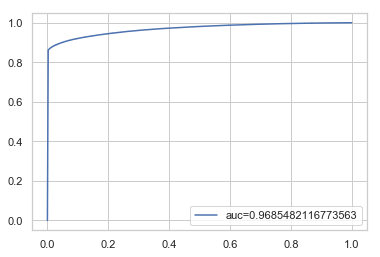


Runtime: 9353.14 seconds


In [39]:
# Fit the data to knn model 
start_time = time.clock()
neigh_pca = KNeighborsClassifier(n_neighbors=25, weights='distance')
neigh_pca.fit(X_train_pca, y_train_pca)
y_knn_pca = neigh_pca.predict(X_eval_pca)

# score
#score_neigh_pca = cross_val_score(neigh_pca, X_pca, Y, cv=10)
#print(score_neigh_pca)
print('Training set score:', neigh_pca.score(X_train_pca, y_train_pca))
print('\nTest set score:', neigh_pca.score(X_eval_pca, y_eval_pca))

# Classification report 
print(classification_report(y_eval_pca, y_knn_pca))

#Confusion matrix 
print('Confusion matrix')
print(confusion_matrix(y_eval_pca, y_knn_pca))

# AUC 
y_pred_proba = neigh_pca.predict_proba(X_eval_pca)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_eval_pca,  y_pred_proba)
auc = metrics.roc_auc_score(y_eval_pca, y_pred_proba)
plt.plot(fpr,tpr,label='auc='+str(auc))
plt.legend(loc=4)
plt.show()
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2)))

PCA has improved the KNN classifier but the issue with overfitting is still present. We have transformed the features for PCA which helps remove unwanted variations in the data which cannot be removed naturally during the data analysis. That coupled with the reduction of possible redunduncy in our data as shown in the heat map has resulted in improved accuracy although overfitting is still present. 

### Logistics Regression with L1 regularization parameter (and PCA)

In [40]:
# Logistic regression with GridSearchCV
start_time = time.clock()
grid_para = C = {'C': [0.001, 0.01, 0.1, 1, 10]}
logreg = GridSearchCV(LogisticRegression(penalty='l1'), grid_para, cv=5)
grid_fit_logreg = logreg.fit(X_train_pca, y_train_pca)
best_logreg_pca = grid_fit_logreg.best_estimator_


# Predict using the test set
y_logreg = best_logreg_pca.predict(X_eval_pca)

Training set score: 0.7280425

Test set score: 0.729785
Confusion matrix
[[152683  47197]
 [ 60889 139231]]
              precision    recall  f1-score   support

           0       0.71      0.76      0.74    199880
           1       0.75      0.70      0.72    200120

   micro avg       0.73      0.73      0.73    400000
   macro avg       0.73      0.73      0.73    400000
weighted avg       0.73      0.73      0.73    400000



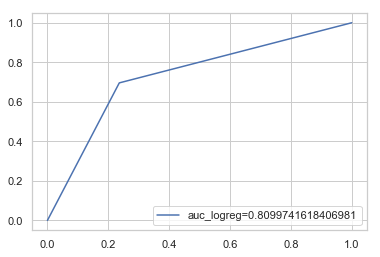


Runtime: 53.65 seconds


In [41]:
# Compare scores for train and test sets
print('Training set score:', logreg.score(X_train_pca, y_train_pca))
print('\nTest set score:', logreg.score(X_eval_pca, y_eval_pca))

# Ten fold cross validation score to evaluate the model *** Took too long 
#score_logreg = cross_val_score(logreg, X_pca, Y, cv=5)
#print(score_logreg)

#Confusion matrix for logistics regression classifier
print('Confusion matrix')
print(confusion_matrix(y_eval_pca, y_logreg))

# Classification report 
print(classification_report(y_eval_pca, y_logreg))

# AUC classifier
y_logreg_proba = best_logreg_pca.predict_proba(X_eval_pca)[::,1]
fpr_logreg, tpr_logreg, _ = metrics.roc_curve(y_eval_pca,  y_logreg)
auc_logreg = metrics.roc_auc_score(y_eval_pca, y_logreg_proba)
plt.plot(fpr_logreg,tpr_logreg,label='auc_logreg='+str(auc_logreg))
plt.legend(loc=4)
plt.show()
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2)))

This model is not improved as a result of PCA. We have used the regularization parameter previously and that seems to have avoided overfitting and multicolinearity of features and the PCA transformation was simply not needed. While doing PCA we have lost some of the varience(10%) in exchange for the dimentional reduction we hoped for and as a result our score has reduced by a small margin.   

### Light GBM with PCA components 

In [42]:
#preparing resampled data for Light GBM
lgb_train_pca = lgb.Dataset(X_train_pca, label=y_train_pca)
lgb_eval_pca = lgb.Dataset(X_eval_pca, y_eval_pca, reference = lgb_train_pca)

In [43]:
# define and train the model with PCA components.
start_time = time.clock()

lgb_model_pca = lgb.train(params, lgb_train_pca, valid_sets = lgb_eval_pca, early_stopping_rounds=15)
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2)))

[1]	valid_0's auc: 0.784187	valid_0's binary_logloss: 0.681147
Training until validation scores don't improve for 15 rounds.
[2]	valid_0's auc: 0.805907	valid_0's binary_logloss: 0.668976
[3]	valid_0's auc: 0.810541	valid_0's binary_logloss: 0.65723
[4]	valid_0's auc: 0.811252	valid_0's binary_logloss: 0.650032
[5]	valid_0's auc: 0.812048	valid_0's binary_logloss: 0.641585
[6]	valid_0's auc: 0.811902	valid_0's binary_logloss: 0.634532
[7]	valid_0's auc: 0.811393	valid_0's binary_logloss: 0.629043
[8]	valid_0's auc: 0.81287	valid_0's binary_logloss: 0.620692
[9]	valid_0's auc: 0.812024	valid_0's binary_logloss: 0.616111
[10]	valid_0's auc: 0.813144	valid_0's binary_logloss: 0.608817
[11]	valid_0's auc: 0.813064	valid_0's binary_logloss: 0.604352
[12]	valid_0's auc: 0.813773	valid_0's binary_logloss: 0.598466
[13]	valid_0's auc: 0.814512	valid_0's binary_logloss: 0.592883
[14]	valid_0's auc: 0.814885	valid_0's binary_logloss: 0.588082
[15]	valid_0's auc: 0.815077	valid_0's binary_logloss

[129]	valid_0's auc: 0.828701	valid_0's binary_logloss: 0.508658
[130]	valid_0's auc: 0.828783	valid_0's binary_logloss: 0.50852
[131]	valid_0's auc: 0.828869	valid_0's binary_logloss: 0.508381
[132]	valid_0's auc: 0.828951	valid_0's binary_logloss: 0.508262
[133]	valid_0's auc: 0.82904	valid_0's binary_logloss: 0.50813
[134]	valid_0's auc: 0.829128	valid_0's binary_logloss: 0.50802
[135]	valid_0's auc: 0.829219	valid_0's binary_logloss: 0.507885
[136]	valid_0's auc: 0.829297	valid_0's binary_logloss: 0.507782
[137]	valid_0's auc: 0.82939	valid_0's binary_logloss: 0.50764
[138]	valid_0's auc: 0.829482	valid_0's binary_logloss: 0.507505
[139]	valid_0's auc: 0.829561	valid_0's binary_logloss: 0.507392
[140]	valid_0's auc: 0.829663	valid_0's binary_logloss: 0.507263
[141]	valid_0's auc: 0.829754	valid_0's binary_logloss: 0.507153
[142]	valid_0's auc: 0.829844	valid_0's binary_logloss: 0.507044
[143]	valid_0's auc: 0.829924	valid_0's binary_logloss: 0.506925
[144]	valid_0's auc: 0.829996	v

[257]	valid_0's auc: 0.837846	valid_0's binary_logloss: 0.496477
[258]	valid_0's auc: 0.837916	valid_0's binary_logloss: 0.496394
[259]	valid_0's auc: 0.838011	valid_0's binary_logloss: 0.496277
[260]	valid_0's auc: 0.838067	valid_0's binary_logloss: 0.496193
[261]	valid_0's auc: 0.838143	valid_0's binary_logloss: 0.496093
[262]	valid_0's auc: 0.838224	valid_0's binary_logloss: 0.495999
[263]	valid_0's auc: 0.838289	valid_0's binary_logloss: 0.495909
[264]	valid_0's auc: 0.838361	valid_0's binary_logloss: 0.495821
[265]	valid_0's auc: 0.838421	valid_0's binary_logloss: 0.495749
[266]	valid_0's auc: 0.838479	valid_0's binary_logloss: 0.49567
[267]	valid_0's auc: 0.83853	valid_0's binary_logloss: 0.495602
[268]	valid_0's auc: 0.838579	valid_0's binary_logloss: 0.495539
[269]	valid_0's auc: 0.838632	valid_0's binary_logloss: 0.495477
[270]	valid_0's auc: 0.838685	valid_0's binary_logloss: 0.495416
[271]	valid_0's auc: 0.838757	valid_0's binary_logloss: 0.495307
[272]	valid_0's auc: 0.8388

[385]	valid_0's auc: 0.845201	valid_0's binary_logloss: 0.487036
[386]	valid_0's auc: 0.845251	valid_0's binary_logloss: 0.486973
[387]	valid_0's auc: 0.845306	valid_0's binary_logloss: 0.486897
[388]	valid_0's auc: 0.845362	valid_0's binary_logloss: 0.486833
[389]	valid_0's auc: 0.845409	valid_0's binary_logloss: 0.486778
[390]	valid_0's auc: 0.845452	valid_0's binary_logloss: 0.486726
[391]	valid_0's auc: 0.845506	valid_0's binary_logloss: 0.48666
[392]	valid_0's auc: 0.845537	valid_0's binary_logloss: 0.486624
[393]	valid_0's auc: 0.845563	valid_0's binary_logloss: 0.48659
[394]	valid_0's auc: 0.845635	valid_0's binary_logloss: 0.486504
[395]	valid_0's auc: 0.845667	valid_0's binary_logloss: 0.486461
[396]	valid_0's auc: 0.845726	valid_0's binary_logloss: 0.486385
[397]	valid_0's auc: 0.845781	valid_0's binary_logloss: 0.486305
[398]	valid_0's auc: 0.845815	valid_0's binary_logloss: 0.486261
[399]	valid_0's auc: 0.845879	valid_0's binary_logloss: 0.486175
[400]	valid_0's auc: 0.8459

[512]	valid_0's auc: 0.852094	valid_0's binary_logloss: 0.478268
[513]	valid_0's auc: 0.852119	valid_0's binary_logloss: 0.478238
[514]	valid_0's auc: 0.852184	valid_0's binary_logloss: 0.478156
[515]	valid_0's auc: 0.852202	valid_0's binary_logloss: 0.478134
[516]	valid_0's auc: 0.852252	valid_0's binary_logloss: 0.47806
[517]	valid_0's auc: 0.852289	valid_0's binary_logloss: 0.478014
[518]	valid_0's auc: 0.85233	valid_0's binary_logloss: 0.477958
[519]	valid_0's auc: 0.852389	valid_0's binary_logloss: 0.477886
[520]	valid_0's auc: 0.852437	valid_0's binary_logloss: 0.477818
[521]	valid_0's auc: 0.852474	valid_0's binary_logloss: 0.477767
[522]	valid_0's auc: 0.852512	valid_0's binary_logloss: 0.477719
[523]	valid_0's auc: 0.852544	valid_0's binary_logloss: 0.477677
[524]	valid_0's auc: 0.85257	valid_0's binary_logloss: 0.477642
[525]	valid_0's auc: 0.852624	valid_0's binary_logloss: 0.477575
[526]	valid_0's auc: 0.852684	valid_0's binary_logloss: 0.4775
[527]	valid_0's auc: 0.852708	

[639]	valid_0's auc: 0.857656	valid_0's binary_logloss: 0.471089
[640]	valid_0's auc: 0.85772	valid_0's binary_logloss: 0.471005
[641]	valid_0's auc: 0.857762	valid_0's binary_logloss: 0.47095
[642]	valid_0's auc: 0.857819	valid_0's binary_logloss: 0.470881
[643]	valid_0's auc: 0.85787	valid_0's binary_logloss: 0.470818
[644]	valid_0's auc: 0.857919	valid_0's binary_logloss: 0.470752
[645]	valid_0's auc: 0.857944	valid_0's binary_logloss: 0.470713
[646]	valid_0's auc: 0.857999	valid_0's binary_logloss: 0.470646
[647]	valid_0's auc: 0.858053	valid_0's binary_logloss: 0.470575
[648]	valid_0's auc: 0.858104	valid_0's binary_logloss: 0.470515
[649]	valid_0's auc: 0.858149	valid_0's binary_logloss: 0.470448
[650]	valid_0's auc: 0.8582	valid_0's binary_logloss: 0.470378
[651]	valid_0's auc: 0.858252	valid_0's binary_logloss: 0.470315
[652]	valid_0's auc: 0.858312	valid_0's binary_logloss: 0.470236
[653]	valid_0's auc: 0.858344	valid_0's binary_logloss: 0.470196
[654]	valid_0's auc: 0.858407	

[767]	valid_0's auc: 0.863411	valid_0's binary_logloss: 0.463542
[768]	valid_0's auc: 0.863445	valid_0's binary_logloss: 0.463497
[769]	valid_0's auc: 0.863482	valid_0's binary_logloss: 0.463447
[770]	valid_0's auc: 0.863514	valid_0's binary_logloss: 0.463404
[771]	valid_0's auc: 0.863552	valid_0's binary_logloss: 0.463352
[772]	valid_0's auc: 0.8636	valid_0's binary_logloss: 0.46329
[773]	valid_0's auc: 0.863644	valid_0's binary_logloss: 0.463235
[774]	valid_0's auc: 0.863678	valid_0's binary_logloss: 0.463188
[775]	valid_0's auc: 0.8637	valid_0's binary_logloss: 0.463158
[776]	valid_0's auc: 0.863733	valid_0's binary_logloss: 0.463111
[777]	valid_0's auc: 0.863766	valid_0's binary_logloss: 0.463062
[778]	valid_0's auc: 0.863803	valid_0's binary_logloss: 0.463013
[779]	valid_0's auc: 0.86385	valid_0's binary_logloss: 0.462952
[780]	valid_0's auc: 0.863887	valid_0's binary_logloss: 0.462901
[781]	valid_0's auc: 0.863928	valid_0's binary_logloss: 0.462849
[782]	valid_0's auc: 0.863972	v

[894]	valid_0's auc: 0.868048	valid_0's binary_logloss: 0.457315
[895]	valid_0's auc: 0.868077	valid_0's binary_logloss: 0.457272
[896]	valid_0's auc: 0.868107	valid_0's binary_logloss: 0.457226
[897]	valid_0's auc: 0.86813	valid_0's binary_logloss: 0.457196
[898]	valid_0's auc: 0.868178	valid_0's binary_logloss: 0.457127
[899]	valid_0's auc: 0.868222	valid_0's binary_logloss: 0.45706
[900]	valid_0's auc: 0.868254	valid_0's binary_logloss: 0.457012
[901]	valid_0's auc: 0.868297	valid_0's binary_logloss: 0.456957
[902]	valid_0's auc: 0.868344	valid_0's binary_logloss: 0.456893
[903]	valid_0's auc: 0.868397	valid_0's binary_logloss: 0.456824
[904]	valid_0's auc: 0.868443	valid_0's binary_logloss: 0.456765
[905]	valid_0's auc: 0.868493	valid_0's binary_logloss: 0.456702
[906]	valid_0's auc: 0.868543	valid_0's binary_logloss: 0.456638
[907]	valid_0's auc: 0.868589	valid_0's binary_logloss: 0.456577
[908]	valid_0's auc: 0.868635	valid_0's binary_logloss: 0.456518
[909]	valid_0's auc: 0.8686

In [44]:
# Convert X_eval_pca to dataframe 
X_eval_pca = pd.DataFrame(X_eval_pca)

In [45]:
# Predict for evaluation set 
X_eval_pca['reordered'] = lgb_model_pca.predict(X_eval_pca, num_iterations = lgb_model_pca.best_iteration)

In [ ]:
df22 = pd.DataFrame(X_eval_pca)

In [46]:
X_eval_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,reordered
0,1.832504,0.389590,0.239184,1.398330,-0.864876,0.252092,-0.339206,0.235871,-0.084232,-0.520739,-1.214874,-0.116988,0.875422
1,1.462261,-1.633275,-0.276254,-0.466107,-0.496919,0.902144,-1.103077,2.169804,0.043501,2.152172,0.821932,0.577783,0.251502
2,1.152168,-1.309893,-0.492898,1.758475,-2.004249,-0.388079,0.316456,-1.444729,-0.593855,-0.618868,-0.382541,0.207502,0.703863
3,-0.141979,0.387571,-0.108590,0.052306,-0.579406,-0.101269,-1.070894,-0.306060,1.479080,-0.766913,0.683189,-0.846907,0.760091
4,0.496946,-0.756089,0.376499,-0.475396,1.785589,0.183578,-0.014081,-0.205724,-1.066406,-1.669409,-1.198750,0.204191,0.179907


In [47]:
# Change to binary for evaluation 
X_eval_pca['reordered']=np.where(X_eval_pca['reordered'] > 0.22, 1, X_eval_pca['reordered'].astype(int))

In [48]:
#Confusion matrix for resampled validation set 
print('Confusion matrix')
print(confusion_matrix(y_eval_pca, X_eval_pca['reordered']))

# Classification report 
print(classification_report(y_eval_pca, X_eval_pca['reordered']))

Confusion matrix
[[ 87307 112573]
 [  4842 195278]]
              precision    recall  f1-score   support

           0       0.95      0.44      0.60    199880
           1       0.63      0.98      0.77    200120

   micro avg       0.71      0.71      0.71    400000
   macro avg       0.79      0.71      0.68    400000
weighted avg       0.79      0.71      0.68    400000



In [49]:
#Accuracy for resampled model
from sklearn.metrics import accuracy_score
accuracy_pca=accuracy_score(X_eval_pca['reordered'],y_eval_pca)
print('Accuracy:', accuracy_pca)

Accuracy: 0.7064625


The results have improved but overall Light GBM is not performing as well logistics regression and KNN classifier. 
Light GBM is a tree based boosting model and decision trees use non-parametric method means that there are no underlying assumptions about the distribution or relation of the features in the data in which case PCA would have added value to the model. The varience we lost while selecting PCA components seems to be more of a factor here than the reduced dimention we get in response and as a result the score has decreased.

## Dimentionality Reduction with Select K Best

In [247]:
# original shape 
X.shape

(1657648, 19)

In [50]:
# Select only two third of the features based on f_classif.
from sklearn.feature_selection import f_classif
selection = SelectKBest(score_func=f_classif, k=13)
X_kbest = selection.fit(X, Y).transform(X)

In [51]:
# Split training and testing data 
X_train_k, X_eval_k, y_train_k, y_eval_k = train_test_split(X_kbest, Y, test_size = 0.2, random_state = 2)

### Logistic Regression With GridSearchCV and Kbest features 

Training set score: 0.739931875

Test set score: 0.740835
Confusion matrix
[[147546  52334]
 [ 51332 148788]]
              precision    recall  f1-score   support

           0       0.74      0.74      0.74    199880
           1       0.74      0.74      0.74    200120

   micro avg       0.74      0.74      0.74    400000
   macro avg       0.74      0.74      0.74    400000
weighted avg       0.74      0.74      0.74    400000



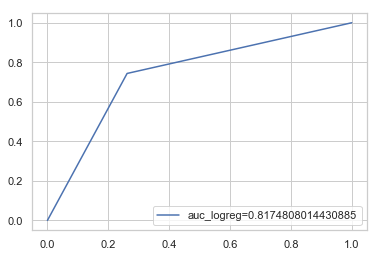


Runtime: 1208.63 seconds


In [52]:
# Logistic regression with GridSearchCV
start_time = time.clock()
grid_para = C = {'C': [0.001, 0.01, 0.1, 1, 10]}
logreg_k = GridSearchCV(LogisticRegression(penalty='l1'), grid_para, cv=5)
grid_fit_logreg_k = logreg_k.fit(X_train_k, y_train_k)
best_logreg_k = grid_fit_logreg_k.best_estimator_


# Predict using the test set
y_logreg_k = best_logreg_k.predict(X_eval_k)

# Compare scores for train and test sets
print('Training set score:', best_logreg_k.score(X_train_k, y_train_k))
print('\nTest set score:', best_logreg_k.score(X_eval_k, y_eval_k))

# Ten fold cross validation score to evaluate the model *** Took too long 
#score_logreg = cross_val_score(best_logreg_k, X_kbest, Y, cv=5)
#print(score_logreg)

#Confusion matrix for logistics regression classifier
print('Confusion matrix')
print(confusion_matrix(y_eval_k, y_logreg_k))

# Classification report 
print(classification_report(y_eval_k, y_logreg_k))

# AUC classifier
y_logreg_proba = best_logreg_k.predict_proba(X_eval_k)[::,1]
fpr_logreg, tpr_logreg, _ = metrics.roc_curve(y_eval_k,  y_logreg_k)
auc_logreg = metrics.roc_auc_score(y_eval_k, y_logreg_proba)
plt.plot(fpr_logreg,tpr_logreg,label='auc_logreg='+str(auc_logreg))
plt.legend(loc=4)
plt.show()
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2)))

The training set score has reduced slightly with fewed features but the overall score has improved slightly. It's not clear how much varience we've lost in the process, but it seems to be a better approach than PCA for logistic Regression. 

### Predicting with Kmeans Clusters. 

We will train a kmeans clustering algorithm and see if it can accurately predict our target variable. The data was too huge for other clustering methods so we will only use kmeans which is relatively easy to train using lower computational power.  

**Use original features to make it possible for analysis of the cluster solutions** 

In [53]:
X_train, X_eval, y_train, y_eval = train_test_split(X, Y, test_size = 0.2, random_state = 2)

### K Means

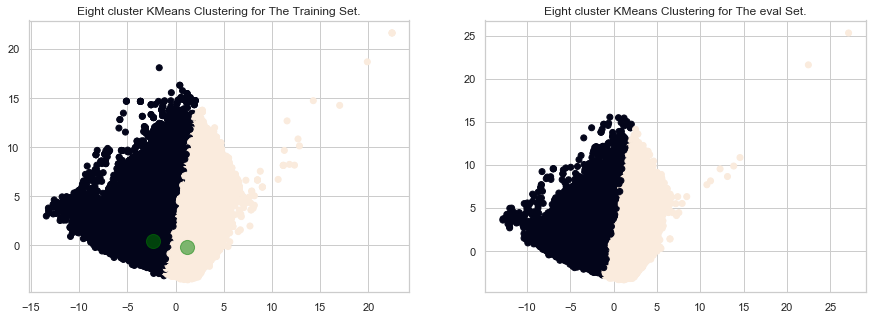

Train set ARI 0.04448408003249094
Eval set ARI 0.04513497597204836


In [60]:
# initialize the algorithm
from sklearn.cluster import KMeans

km = KMeans(n_clusters = 2, random_state=2) 

# Calculate predicted values
y_pred_km = km.fit_predict(X_train_pca)
# predict eval set clusters 
y_pred_km_eval = km.predict(X_eval_pca)

# Plot the solution using the first 2 pca components 
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_pred_km)
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='green', s=200, alpha=0.5)# Green dots show cluster centers. 
plt.title('Eight cluster KMeans Clustering for The Training Set.')

plt.subplot(122)
plt.scatter(X_eval_pca[:, 0], X_eval_pca[:, 1], c=y_pred_km_eval)
plt.title('Eight cluster KMeans Clustering for The eval Set.')
plt.show()

# adjusted rand index
print('Train set ARI', metrics.adjusted_rand_score(y_train_pca, y_pred_km))
print('Eval set ARI', metrics.adjusted_rand_score(y_eval_pca, y_pred_km_eval))

The Adjusted Rand index score shows that this clustering is close random. A perfect cluster has a value of 1 and a random assignment has a value of 0.5. This is not a good cluster and we'll make a couple of graphical comparisions to see the difference with the ground truth. As can be seen from the graphs there is a difference between the ground truth and the clustering solution. 

k-means is a varience minimization algorithm and assumes the variance of the distribution of each variable is spherical (uniform in all directions), all variables have the same variance, and that each cluster has roughly equal number of observations. It assumes that the inertia (cost function) $\sum(\bar{x}_c - x_i)^2$ is equally relevant for all variables and data points meaning that we'll have problems with skiewed distributions and with variables that are not continioius as we have in our dataset. 

In [61]:
# Column for assigned cluster in the train and eval sets 
X_train['cluster'] = y_pred_km
X_eval['cluster'] = y_pred_km_eval

In [62]:
# add the ground truth for comparision
X_train['reorder'] = y_train

In [63]:
# inspect changes
X_train.head()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last,cluster,reorder
6383418,3150761,24852,10,45,37,18.000000,4.500000,16,25.0,1.388889,24,4,472565,398609.0,0.843501,1,0.100000,1.000000,0.100000,9,4,1,0
5648311,813790,30827,56,667,108,6.636364,11.910714,12,1.0,0.150685,32,4,13571,9841.0,0.725149,26,0.464286,8.692307,0.464286,2,4,0,1
3557332,381797,3192,17,125,62,14.250000,7.352941,11,14.0,0.982456,122,12,622,314.0,0.504823,2,0.117647,8.000000,0.117647,3,7,1,1
7763711,3151128,2186,35,638,222,10.705882,18.228571,11,7.0,0.653846,4,9,493,195.0,0.395538,1,0.028571,18.000000,0.028571,23,4,0,0
2925860,3406102,35004,100,1495,185,2.737374,14.950000,12,5.0,1.826568,4,9,8200,4309.0,0.525488,17,0.170000,16.235294,0.170000,2,3,0,1


The count plot below shows that the cluster solution is very different from the ground truth. 

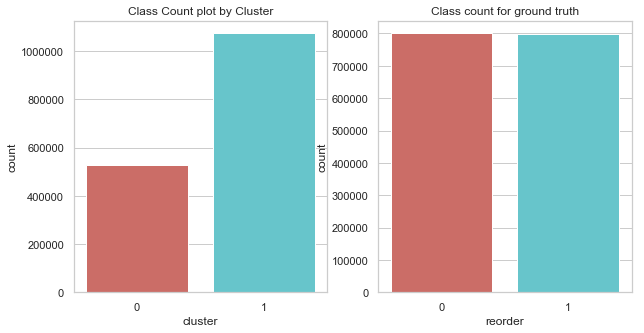

In [64]:
# Count plot of each classes for cluster solution and ground truth 
plt.figure(figsize=(10,5))
plt.subplot(121)
sns.countplot(x='cluster', data=X_train, palette='hls')
plt.title('Class Count plot by Cluster')

plt.subplot(122)
sns.countplot(x='reorder', data=X_train, palette='hls')
plt.title('Class count for ground truth')

plt.show()

The following is an example of differenced between ground truth and clustering solution. 

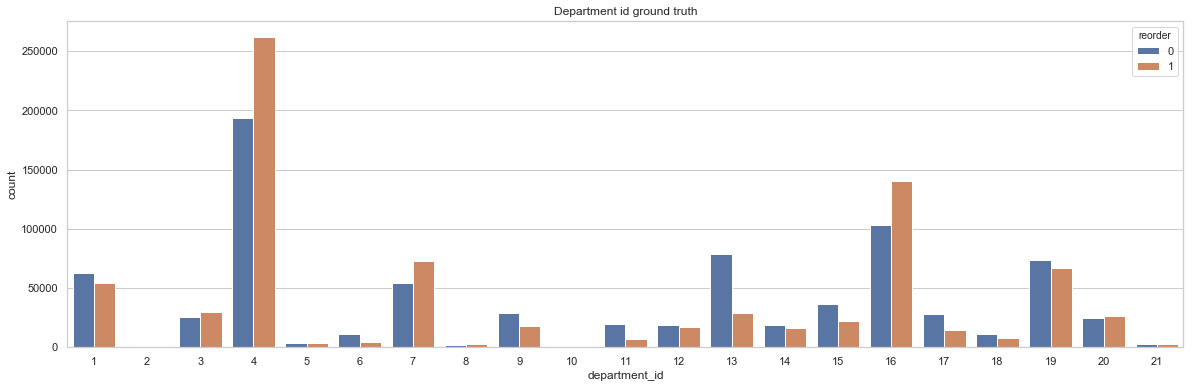

In [65]:
# Department id in ground truth 
plt.figure(figsize=(20, 6))
sns.countplot('department_id', data=X_train, hue = 'reorder')
plt.title('Department id ground truth')

plt.show()

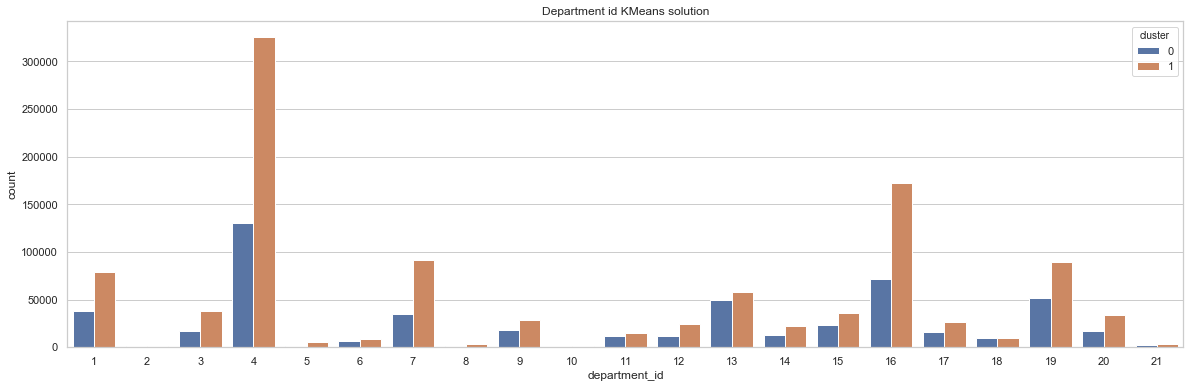

In [66]:
# Department id in cluster solution 
plt.figure(figsize=(20, 6))
sns.countplot('department_id', data=X_train, hue = 'cluster')
plt.title('Department id KMeans solution')

plt.show()

### Generate more clusters as a feature for supervised learning

Now we will try to use kmeans clustering to create additional feature to the data set which then can be used to try and improve the supervised model algorithms above. We will only apply this approach on the best performing model so far. We will use the elbow method to select optimal K value by plotting the sum of square errors verses different K values. In our graph, the optimal K value is 5. 

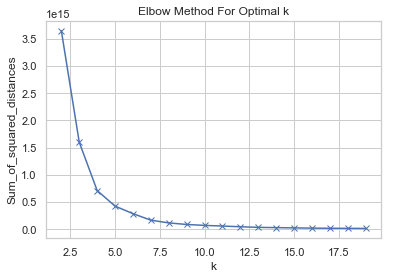

In [262]:
# Elbow graph to select optimal K 
from sklearn.cluster import KMeans
X_km = X
Sum_of_squared_distances = []
K = range(2,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

We now create a cluster based using five clusters 

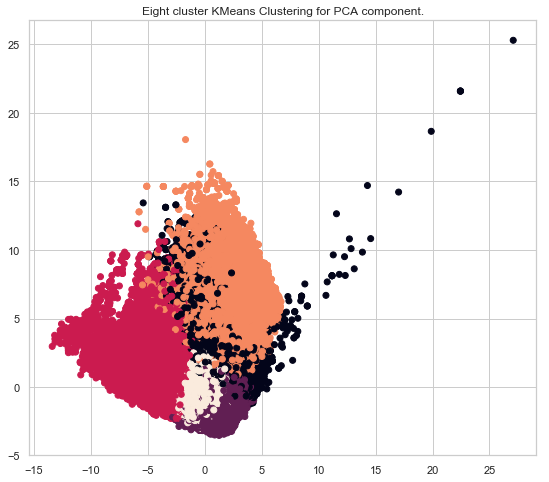

0.03748379598093332

Runtime: 198.89 seconds


In [67]:
# Create a cluster to be added to PCA component before train test split
start_time = time.clock()
# initialize the algorithm
km_pca = KMeans(n_clusters = 5, random_state=42) 

# Calculate predicted values
y_pred_km_pca = km_pca.fit_predict(X_pca)

# Plot the solution using the first 2 lsa components 
plt.figure(figsize=(20,8))

plt.subplot(121)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_km_pca)
plt.title('Eight cluster KMeans Clustering for PCA component.')

plt.show()
print(metrics.adjusted_rand_score(Y, y_pred_km_pca))
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2)))

In [68]:
# Create a dataframe for the cluster and join with X_pca as a feature
cluster = pd.DataFrame(y_pred_km_pca)
cluster.columns = ['cluster']

In [69]:
# Convert to dataframe for merging 
X_pca_df = pd.DataFrame(X_pca)

In [70]:
# Add the outcome back onto X_pca
X_pca_clu = X_pca_df.join(cluster, how='inner')

In [71]:
# inspect changes
X_pca_clu.head()

,0,1,2,3,4,5,6,7,8,9,10,11,cluster
0,0.483614,0.606951,0.158841,1.217925,-0.570393,0.228542,-1.340051,1.032473,0.263030,0.907111,-1.260193,0.190990,4
1,1.657046,0.354198,-1.033918,0.655761,-0.829803,0.434065,-1.965407,-1.001753,-0.732012,0.263739,-0.434459,-0.255671,4
2,0.587209,0.331918,0.034261,0.941503,0.659178,-0.474646,-0.757541,1.444475,-0.986117,-1.125017,0.206761,-0.749581,4
3,0.855684,-1.436544,-0.699796,-1.135034,0.402572,-0.119530,0.296303,-1.303801,1.101414,1.788032,-0.329314,0.535244,1
4,2.180047,-1.527201,0.123127,1.005169,-0.579621,0.829322,0.392799,-1.458722,-1.522040,0.310858,-1.071489,0.410851,1


We have a new feature and now we will train the logistic regression model which gave us a better result previously and see if we can improve the model.  

In [72]:
# Train test split 
X_train_clu, X_eval_clu, y_train_clu, y_eval_clu = train_test_split(X_pca_clu, Y, test_size = 0.2, random_state = 2)

### Logistic Regression with KMeans Cluster Feature

In [73]:
# Logistic regression with GridSearchCV
start_time = time.clock()
grid_para = C = {'C': [0.001, 0.01, 0.1, 1, 10]}
logreg = GridSearchCV(LogisticRegression(penalty='l1'), grid_para, cv=5)
grid_fit_logreg = logreg.fit(X_train_clu, y_train_clu)
best_logreg_clu = grid_fit_logreg.best_estimator_


# Predict using the test set
y_logreg = best_logreg_clu.predict(X_eval_clu)

Training set score: 0.72824

Test set score: 0.7296775
Confusion matrix
[[152627  47253]
 [ 60876 139244]]
              precision    recall  f1-score   support

           0       0.71      0.76      0.74    199880
           1       0.75      0.70      0.72    200120

   micro avg       0.73      0.73      0.73    400000
   macro avg       0.73      0.73      0.73    400000
weighted avg       0.73      0.73      0.73    400000



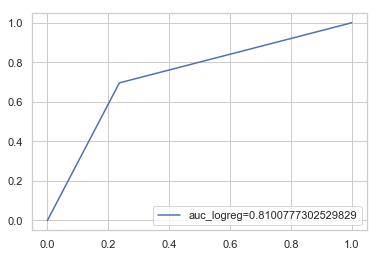


Runtime: 118.92 seconds


In [74]:
# Compare scores for train and test sets
print('Training set score:', best_logreg_clu.score(X_train_clu, y_train_clu))
print('\nTest set score:', best_logreg_clu.score(X_eval_clu, y_eval_clu))

# Ten fold cross validation score to evaluate the model *** Took too long 
#score_logreg = cross_val_score(logreg, X_pca_clu, Y, cv=5)
#print(score_logreg)

#Confusion matrix for logistics regression classifier
print('Confusion matrix')
print(confusion_matrix(y_eval_clu, y_logreg))

# Classification report 
print(classification_report(y_eval_clu, y_logreg))

# AUC classifier
y_logreg_proba = best_logreg_clu.predict_proba(X_eval_clu)[::,1]
fpr_logreg, tpr_logreg, _ = metrics.roc_curve(y_eval_clu,  y_logreg)
auc_logreg = metrics.roc_auc_score(y_eval_clu, y_logreg_proba)
plt.plot(fpr_logreg,tpr_logreg,label='auc_logreg='+str(auc_logreg))
plt.legend(loc=4)
plt.show()
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2)))

As the adjusted rand index indicated, the cluster is close to random and as shown in the model above, it does not improve the results for reasones mentioned previously. 

## Neural Network Models
Finally we will use Neural Network models for prediction. We will apply Multi Layer Perceptron Model(MLP) and Convolutional Neural Net (CNN)

### Multi Layer Perceptrons (MLP)

In [33]:
# Import componenets
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, MaxPooling1D, BatchNormalization, Activation, Conv1D, Conv2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf


# Import the backend
from keras import backend as K

In [31]:
from keras.layers import AveragePooling1D

We will use the data without applying PCA because neural nets can approximate any nonlinear mapping through learning and are free from the constraints of a non-linear model. In addition, dimensionality reduction could lead to loss of information which may be useful for training the model.

We'll use Sci-kit learn to build our MLP model. 

In [50]:
# split the resampled train data for evaluation 
# work with resampled data with out pca 
X_train_nn, X_eval_nn, y_train_nn, y_eval_nn = train_test_split(
    X, Y, test_size=0.2, random_state=2)

In [51]:
start_time = time.clock()
# Now apply the transformations to the data:
X_train_nn = StandardScaler().fit_transform(X_train_nn)
X_eval_nn = StandardScaler().fit_transform(X_eval_nn)
mlp = MLPClassifier(hidden_layer_sizes=(64, 64, 32, 16, 2), random_state=42, verbose=True, early_stopping=True, batch_size=256)
mlp.fit(X_train_nn, y_train_nn)
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2)))

Iteration 1, loss = 0.51873486
Validation score: 0.750144
Iteration 2, loss = 0.51130531
Validation score: 0.750737
Iteration 3, loss = 0.50946637
Validation score: 0.751706
Iteration 4, loss = 0.50816852
Validation score: 0.752031
Iteration 5, loss = 0.50738657
Validation score: 0.752969
Iteration 6, loss = 0.50663670
Validation score: 0.752881
Iteration 7, loss = 0.50612812
Validation score: 0.752744
Iteration 8, loss = 0.50571614
Validation score: 0.753644
Iteration 9, loss = 0.50531857
Validation score: 0.753944
Iteration 10, loss = 0.50511051
Validation score: 0.753831
Iteration 11, loss = 0.50467628
Validation score: 0.752931
Iteration 12, loss = 0.50438663
Validation score: 0.754150
Iteration 13, loss = 0.50413611
Validation score: 0.754313
Iteration 14, loss = 0.50388469
Validation score: 0.753725
Iteration 15, loss = 0.50355918
Validation score: 0.754131
Iteration 16, loss = 0.50335371
Validation score: 0.754088
Iteration 17, loss = 0.50306151
Validation score: 0.753894
Iterat

In [78]:
# Predict for eval_set
predictions = mlp.predict(X_eval_nn)

In [79]:
# Scores
print('Train set score', mlp.score(X_train_nn, y_train_nn, sample_weight=None))
print('Eval set score', mlp.score(X_eval_nn, y_eval_nn, sample_weight=None))

Train set score 0.753816875
Eval set score 0.7531925


In [80]:
print(confusion_matrix(y_eval_nn, predictions))

[[149774  50106]
 [ 48617 151503]]


In [81]:
print(classification_report(y_eval_nn, predictions))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75    199880
           1       0.75      0.76      0.75    200120

   micro avg       0.75      0.75      0.75    400000
   macro avg       0.75      0.75      0.75    400000
weighted avg       0.75      0.75      0.75    400000



The Multi Layer Perceptron model gives us predictions with evaluation scores slightly better thatn Logistics regression. Let's see if CNN model can improve the score.  

## Convolutional Neural Networks (CNN)
CNNs were designed to map image data to an output variable.It generally works well well with data sets that have spatial relationship like images, or sequential relationship like time series data. Our data set has no sequential or spatial relationship between the data points and as a result CNN may not be the ideal model.  

In [41]:
# split the resampled train data for evaluation 
# work with resampled data with out pca 
X_train_cnn, X_eval_cnn, y_train_cnn, y_eval_cnn = train_test_split(
    X, Y, test_size=0.2, random_state=2)

In [24]:
# reshape the data
X_train_cnn = np.expand_dims(X_train_cnn, axis=2)
X_eval_cnn = np.expand_dims(X_eval_cnn, axis=2)

In [25]:
# Check shape 
X_train_cnn.shape

(1600000, 21, 1)

In [111]:
# check shape
X_eval_cnn.shape

(400000, 21, 1)

In [26]:
# Build CNN model
start_time = time.clock()
num_classes = 2
X_train_cnn = X_train_cnn.astype('float32')
X_test = X_eval_cnn.astype('float32')

print('X_train_cnn shape:', X_train_cnn.shape)
print(X_train_cnn.shape[0], 'train samples')
print(X_eval_cnn.shape[0], 'eval samples')

# reshape input data
#X_train_cnn = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1], 1)

# convert class vectors to binary class matrices
y_train_cnn = keras.utils.to_categorical(y_train_cnn, num_classes)
y_eval_cnn = keras.utils.to_categorical(y_eval_cnn, num_classes)

X_train_cnn shape: (1600000, 21, 1)
1600000 train samples
400000 eval samples


In [37]:
# Building the Model
model = Sequential()
# First convolutional layer, note the specification of shape
model.add(Conv1D(filters=64, kernel_size=6, activation='relu', input_shape = (21, 1)))
model.add(Conv1D(filters=64, kernel_size=6, activation='relu'))
model.add(Dropout(0.5))

model.add(AveragePooling1D(pool_size=3, stride=2, data_format='channels_last', padding='valid',))

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(64, activation='relu', use_bias=False))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(64, activation='relu', use_bias=False))
model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(32, activation='relu', use_bias=False))
model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(16, activation='relu', use_bias=False))
model.add(BatchNormalization())

model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(epsilon=1e-08),
              metrics=['accuracy'])

model.fit(X_train_cnn, y_train_cnn,
          batch_size=256,
          epochs=15,
          verbose=1,
          validation_data=(X_eval_cnn, y_eval_cnn))
score = model.evaluate(X_eval_cnn, y_eval_cnn, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2)))

Train on 1600000 samples, validate on 400000 samples
Epoch 1/15
1600000/1600000 [==============================] - 155s 97us/step - loss: 0.6730 - acc: 0.5798 - val_loss: 0.6411 - val_acc: 0.6347
Epoch 2/15
1600000/1600000 [==============================] - 161s 100us/step - loss: 0.6326 - acc: 0.6468 - val_loss: 0.5995 - val_acc: 0.6869
Epoch 3/15
1600000/1600000 [==============================] - 159s 99us/step - loss: 0.5897 - acc: 0.6930 - val_loss: 0.5599 - val_acc: 0.7123
Epoch 4/15
1600000/1600000 [==============================] - 160s 100us/step - loss: 0.5670 - acc: 0.7141 - val_loss: 0.5653 - val_acc: 0.7265
Epoch 5/15
1600000/1600000 [==============================] - 162s 101us/step - loss: 0.5571 - acc: 0.7233 - val_loss: 0.5466 - val_acc: 0.7319
Epoch 6/15
1600000/1600000 [==============================] - 160s 100us/step - loss: 0.5548 - acc: 0.7259 - val_loss: 0.5528 - val_acc: 0.7287
Epoch 7/15
1600000/1600000 [==============================] - 161s 100us/step - loss:

The accuracy score is very high given the nature of the data set. We have used normalization layer to normalize the output of a previous layer befor feeding it to the next layer which highly contributed to improving the accuracy. The kernel-size in the convolution layers is set to six as an attempt to give the model to find patterns in a lenght similar to the average basket size of users. Yet, it's an arbitrary assignment but has produced a better result than fewer kernel size values.  

## Predict for the test set using the best model

The best model so far is MLP and we will use it to make a prediction for the final test set which is similar to applying it to production. 

In [53]:
# define test set the same way we did train set 
df_test, _ = features(test_orders)

build candidate list


In [56]:
#
df_test.head()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last
0,2774568,17668,13,88,33,12.0,6.769231,15,11.0,0.916667,91,16,2110,1220.0,0.578199,5,0.384615,3.60,0.384615,2,3
1,2774568,44683,13,88,33,12.0,6.769231,15,11.0,0.916667,83,4,22275,11981.0,0.537868,2,0.153846,9.50,0.153846,7,1
2,2774568,48523,13,88,33,12.0,6.769231,15,11.0,0.916667,37,1,5129,2376.0,0.463248,2,0.153846,6.50,0.153846,4,1
3,2774568,21903,13,88,33,12.0,6.769231,15,11.0,0.916667,123,4,241921,186884.0,0.772500,8,0.615385,4.25,0.615385,1,0
4,2774568,14992,13,88,33,12.0,6.769231,15,11.0,0.916667,83,4,29069,16942.0,0.582820,2,0.153846,7.00,0.153846,6,0


In [55]:
df_test.shape

(4833292, 21)

In [57]:
# predict for test set using a lower threshold  
df_test['reorder'] = (mlp.predict_proba(df_test)[:,1] >= 0.21).astype(int)

In [58]:
# Inspect prediction 
df_test.tail()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last,reorder
4833287,803273,44532,50,677,198,7.367347,13.54,11,4.0,0.542936,3,19,311,124.0,0.398714,1,0.02,11.000000,0.02,7,3,1
4833288,803273,46069,50,677,198,7.367347,13.54,11,4.0,0.542936,123,4,9240,5420.0,0.586580,7,0.14,5.571429,0.14,4,1,1
4833289,803273,12791,50,677,198,7.367347,13.54,11,4.0,0.542936,3,19,1393,755.0,0.541996,1,0.02,12.000000,0.02,7,3,1
4833290,803273,14332,50,677,198,7.367347,13.54,11,4.0,0.542936,72,13,6046,1424.0,0.235528,1,0.02,9.000000,0.02,8,8,1
4833291,803273,4605,50,677,198,7.367347,13.54,11,4.0,0.542936,83,4,73167,43269.0,0.591373,1,0.02,18.000000,0.02,9,3,0


In [59]:
# Count of reordered class in the test set 
df_test['reorder'].value_counts()

1    4340288
0     493004
Name: reorder, dtype: int64

In [60]:
# use dictionary to map the reordered products to user ids 
d = dict()
for row in df_test.itertuples():
    if row.reorder == 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

result_mlp = pd.DataFrame.from_dict(d, orient='index')

result_mlp.reset_index(inplace=True)
result_mlp.columns = ['order_id', 'products']
result_mlp.to_csv('result.csv', index=False)


In [61]:
#Final prediction 
result_mlp.head()

,order_id,products
0,2774568,17668 44683 48523 14992 32402 22035 49683 3919...
1,329954,21573 42329 17769 35469 1200 26576 2707 25623 ...
2,1528013,40992 27521 20323 48679 8424 10644 38293 49401...
3,1376945,17794 8197 30855 33037 30480 10644 35738 15261...
4,1356845,11520 45056 17794 44422 17159 44683 37646 1499...


In [62]:
# should be 75000
result_mlp.shape

(75000, 2)

## Conclusion and Recommendation 

The dataset is difficult to train and the best accuracy score we get is 75%. I suspect that people's grocery shopping habbits are more predictible than this but this dataset is heavily anonymized for privacy reasons and in the process potentially valuable information is lost especially a user label data such as age and gender. When users go to the app to order, one of the first thing they must do is enter a zip code and choose a specific store in that area. Which means that knowing the name of the store and location of users or location of stores will be a good indicator. 

We have used KNN Classifier, Logistic Regression, Light GBM boosting model as well as Neural Networks (MLP and CNN). The model selection is limited by computational power and and time constraint. We have tried to improve the models using PCA and SelectkBest for dimentioality reduction as well as parameter tuning using GridSearchCV. 


MLP is the model I choose for implementation. It has better accuracy (**75%**), precision, and recall scores. The score for the training set is also 75% which means it has handled overfitting well. The relationship between the datapoints may not be linear but MLP is able to make non linear transformations and learn better than the other models we tried. There is also a posibility to improve the score using more parameter tuning which was not possible to do here because of the computational power it needed. It should also be noted that Logistic Regression is only slightly lower than MLP in performance.  

MLP models learn better with more data and in production environment the new observations will make it better if deployed in a way that feeds it back to the model. To make the prediction better, more informative data is needed such as demographic and store related data. As mentioned earlier, the approach used for making predictions in this project is by creating a list of user-product pairs based on previous data and predicting the likelihood that that product will be ordered by that user. There could be other approached which could result in a better prediction and it is worth exploring them.  